In [33]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("customer_journey.csv")
df = df.dropna()
# convert timestamp column into datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
# sort by UserID, SessionID, Timestamp
df = df.sort_values(by=["UserID", "SessionID", "Timestamp"])
df


,SessionID,UserID,Timestamp,PageType,DeviceType,Country,ReferralSource,TimeOnPage_seconds,ItemsInCart,Purchased
7433,session_2922,user_1001,2025-03-30 08:27:58,home,Desktop,Germany,Google,89,0,1
7434,session_2922,user_1001,2025-03-30 08:29:35,product_page,Desktop,Germany,Google,97,3,1
7435,session_2922,user_1001,2025-03-30 08:30:29,cart,Desktop,Germany,Google,54,3,1
7436,session_2922,user_1001,2025-03-30 08:32:37,checkout,Desktop,Germany,Google,128,3,1
7437,session_2922,user_1001,2025-03-30 08:34:48,confirmation,Desktop,Germany,Google,131,0,1
...,...,...,...,...,...,...,...,...,...,...
10494,session_4128,user_3001,2025-05-04 16:04:04,home,Tablet,Germany,Social Media,171,0,1
10495,session_4128,user_3001,2025-05-04 16:06:38,product_page,Tablet,Germany,Social Media,154,3,1
10496,session_4128,user_3001,2025-05-04 16:06:58,cart,Tablet,Germany,Social Media,20,3,1
10497,session_4128,user_3001,2025-05-04 16:08:01,checkout,Tablet,Germany,Social Media,63,3,1


In [34]:
# group data and aggregate the same sessionID into one line
# Build the funnel path for each SessionID
# Compute session duration 
session_summary = df[~df["PageType"].isin(["confirmation"])].copy()
session_summary = (
    session_summary.groupby(["UserID", "SessionID"])
    .agg(
        Funnel_Path=("PageType", lambda x: ",".join(x)),
        session_start=("Timestamp", "min"),
        session_end=("Timestamp", "max"),
        DeviceType=("DeviceType", "first"),
        Duration_seconds=("TimeOnPage_seconds", "sum"),
        Country=("Country", "first"),
        ItemsInCart=("ItemsInCart","max"),
        ReferralSource=("ReferralSource", "first"),
        Purchased=("Purchased", "max")
    )
    .reset_index()
)


# Reorder and clean up columns to get post-processed data
session_summary = session_summary[
    ["UserID", "SessionID", "Country", "ReferralSource","DeviceType", "session_end", "Funnel_Path", "ItemsInCart", "Duration_seconds", "Purchased"]
]

session_summary


,UserID,SessionID,Country,ReferralSource,DeviceType,session_end,Funnel_Path,ItemsInCart,Duration_seconds,Purchased
0,user_1001,session_2922,Germany,Google,Desktop,2025-03-30 08:32:37,"home,product_page,cart,checkout",3,368,1
1,user_1001,session_4102,Canada,Email,Mobile,2025-02-26 15:48:09,"home,product_page",3,152,0
2,user_1002,session_2118,Germany,Social Media,Tablet,2025-06-10 07:30:46,"home,product_page,cart,checkout",5,574,1
3,user_1002,session_2943,France,Email,Mobile,2025-05-20 07:03:29,"home,product_page",0,136,0
4,user_1004,session_1089,Germany,Google,Tablet,2025-02-03 08:57:13,home,0,98,0
...,...,...,...,...,...,...,...,...,...,...
4995,user_3000,session_4719,Australia,Social Media,Desktop,2025-04-22 23:42:16,"home,product_page,cart,checkout",2,377,1
4996,user_3001,session_1218,Australia,Google,Mobile,2025-08-03 08:29:43,"home,product_page",3,183,0
4997,user_3001,session_2121,France,Google,Mobile,2025-07-14 09:32:17,"home,product_page,cart,checkout",2,441,1
4998,user_3001,session_3987,France,Google,Mobile,2025-01-08 16:48:25,"home,product_page",4,100,0


     Country  total_sessions  sessions_purchased  purchase_rate_%
0  Australia             683                 131            19.18
1     Canada             715                 140            19.58
2     France             752                 170            22.61
3    Germany             703                 132            18.78
4      India             702                 145            20.66
5         UK             739                 145            19.62
6        USA             706                 147            20.82


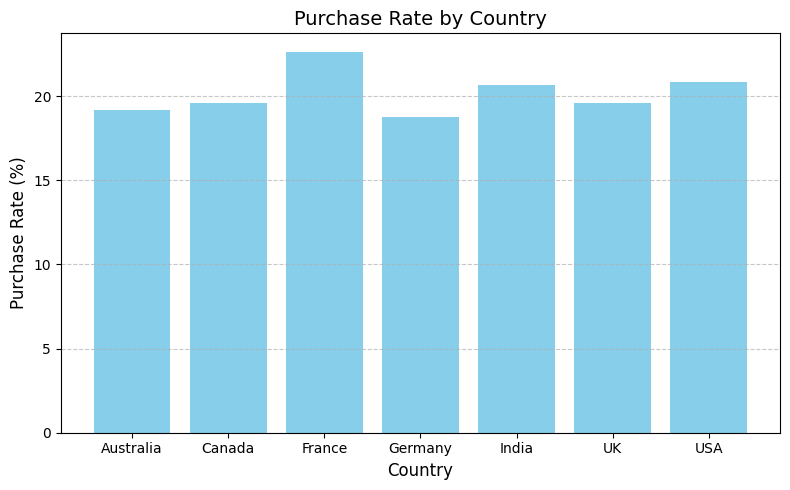

In [35]:
# where users come from and how that affects the purchase rate
country_purchase = (
    session_summary.groupby("Country")
    .agg(
        total_sessions=("SessionID", "count"),
        sessions_purchased=("Purchased", "sum")
    )
    .reset_index()
)
# calculate the purchase rate for country
country_purchase["purchase_rate_%"] = (
    country_purchase["sessions_purchased"] / country_purchase["total_sessions"] * 100
).round(2)

print(country_purchase)

# draw the graph
plt.figure(figsize=(8, 5))
plt.bar(country_purchase["Country"], country_purchase["purchase_rate_%"], color="skyblue")
plt.title("Purchase Rate by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Purchase Rate (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


  ReferralSource  total_sessions  sessions_purchased  purchase_rate_%
0         Direct            1226                 243            19.82
1          Email            1251                 251            20.06
2         Google            1280                 277            21.64
3   Social Media            1243                 239            19.23


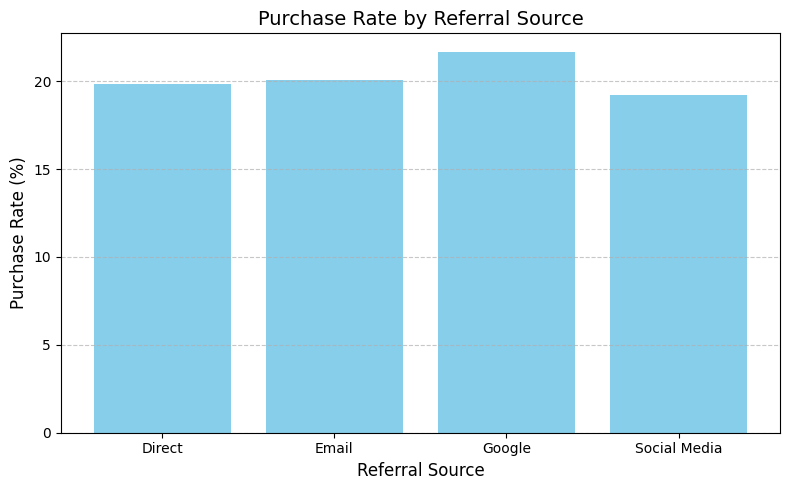

In [36]:
referral_purchase = (
    session_summary.groupby("ReferralSource")
    .agg(
        total_sessions=("SessionID", "count"),
        sessions_purchased=("Purchased", "sum")
    )
    .reset_index()
)
# calculate the purchase rate for each referral source
referral_purchase["purchase_rate_%"] = (
    referral_purchase["sessions_purchased"] / referral_purchase["total_sessions"] * 100
).round(2)

print(referral_purchase)

plt.figure(figsize=(8, 5))
plt.bar(referral_purchase["ReferralSource"], referral_purchase["purchase_rate_%"], color="skyblue")
plt.title("Purchase Rate by Referral Source", fontsize=14)
plt.xlabel("Referral Source", fontsize=12)
plt.ylabel("Purchase Rate (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


   ItemsInCart  total_sessions  items_purchased  purchase_rate_%
0            0            2088                0             0.00
1            1             568              214            37.68
2            2             569              197            34.62
3            3             668              255            38.17
4            4             561              175            31.19
5            5             546              169            30.95


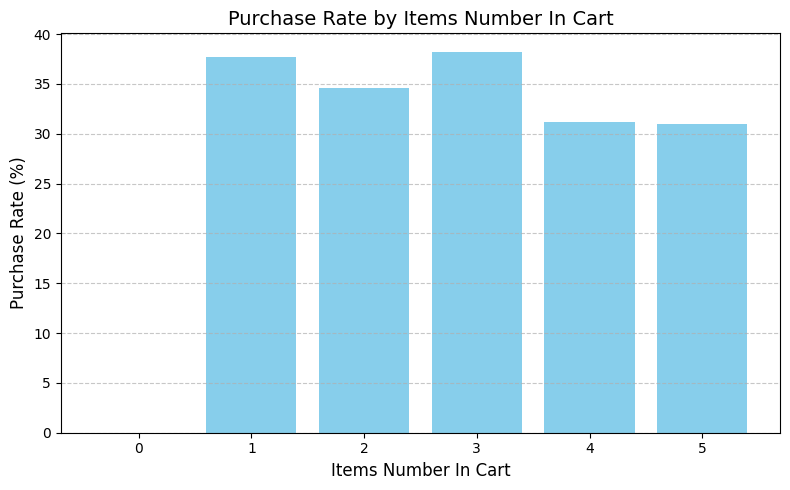

In [37]:
ItemsInCart_purchase = (
    session_summary.groupby("ItemsInCart")
    .agg(
        total_sessions=("SessionID", "count"),
        items_purchased=("Purchased", "sum")
    )
    .reset_index()
)
# calculate the purchase rate for each 
ItemsInCart_purchase["purchase_rate_%"] = (
    ItemsInCart_purchase["items_purchased"] / ItemsInCart_purchase["total_sessions"] * 100
).round(2)

print(ItemsInCart_purchase)

plt.figure(figsize=(8, 5))
plt.bar(ItemsInCart_purchase["ItemsInCart"], ItemsInCart_purchase["purchase_rate_%"], color="skyblue")
plt.title("Purchase Rate by Items Number In Cart", fontsize=14)
plt.xlabel("Items Number In Cart", fontsize=12)
plt.ylabel("Purchase Rate (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


     Month  Purchased
0  2025-01        126
1  2025-02        110
2  2025-03        135
3  2025-04        118
4  2025-05        129
5  2025-06        128
6  2025-07        133
7  2025-08        131


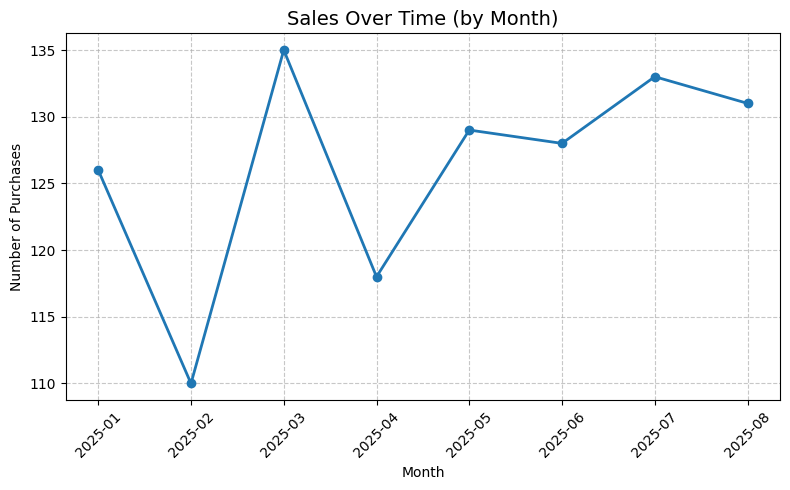

In [38]:
session_summary["Month"] = session_summary["session_end"].dt.to_period("M").astype(str)

# group data by month and calculate total sales per month 
sales_by_month = (
    session_summary.groupby("Month")["Purchased"]
    .sum()
    .reset_index()
)
print(sales_by_month)

plt.figure(figsize=(8, 5))
plt.plot(
    sales_by_month["Month"],
    sales_by_month["Purchased"],
    marker="o",
    linewidth=2,
    color="tab:blue"
)
plt.title("Sales Over Time (by Month)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()


    Hour  total_sessions  hour_purchased  purchase_rate_%
0      0             228              51            22.37
1      1             181              37            20.44
2      2             177              40            22.60
3      3             202              40            19.80
4      4             207              37            17.87
5      5             194              39            20.10
6      6             218              36            16.51
7      7             191              39            20.42
8      8             207              35            16.91
9      9             220              48            21.82
10    10             218              42            19.27
11    11             208              45            21.63
12    12             204              42            20.59
13    13             219              44            20.09
14    14             217              43            19.82
15    15             226              54            23.89
16    16      

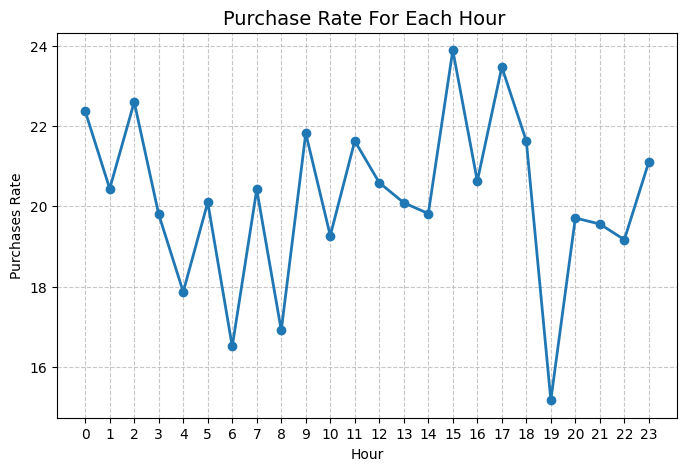

In [39]:
session_summary["Hour"] = session_summary["session_end"].dt.hour.astype(int)
# group data by month and calculate total sales per month 
sales_by_hour = (
    session_summary.groupby("Hour")
     .agg(
        total_sessions=("SessionID", "count"),
        hour_purchased=("Purchased", "sum")
    )
    .reset_index()
)


sales_by_hour["purchase_rate_%"] = (
    sales_by_hour["hour_purchased"] / sales_by_hour["total_sessions"] * 100
).round(2)
print(sales_by_hour)
plt.figure(figsize=(8, 5))
plt.plot(
    sales_by_hour["Hour"],
    sales_by_hour["purchase_rate_%"],
    marker="o",
    linewidth=2,
    color="tab:blue"
)
plt.title("Purchase Rate For Each Hour ", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Purchases Rate")
plt.xticks(range(24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


670
   Duration_bin  total_sessions_per_bin  bin_purchased  purchase_rate_%
0          0-49                     226              0             0.00
1         50-99                     514              1             0.19
2       100-149                     721              4             0.55
3       150-199                     909             23             2.53
4       200-249                     701             54             7.70
5       250-299                     632            111            17.56
6       300-349                     452            170            37.61
7       350-399                     276            182            65.94
8       400-449                     245            178            72.65
9       450-499                     160            141            88.12
10      500-549                     107             93            86.92
11      550-599                      43             39            90.70
12      600-649                      13             13      

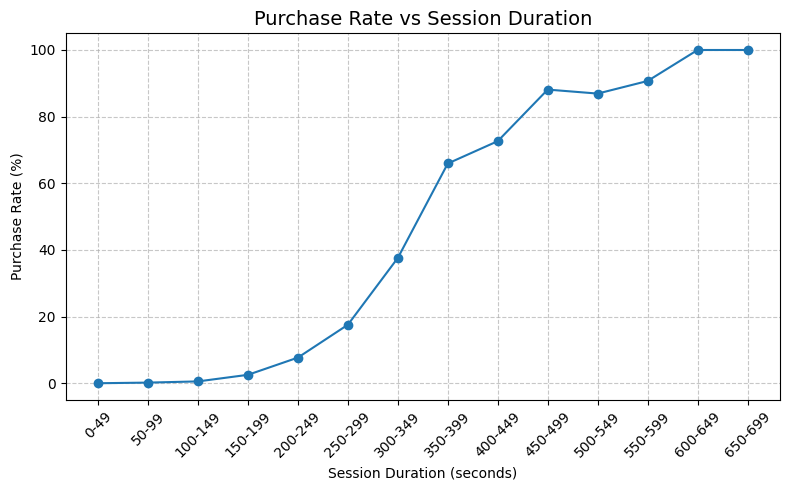

In [40]:
# create bins for duration time
print(session_summary["Duration_seconds"].max())
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850]
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
session_summary["Duration_bin"] = pd.cut(session_summary["Duration_seconds"], bins=bins, labels=labels, right=False)

# group data by duration bin and calculate purchase rate per bin
purchase_rate_by_bin = (
    session_summary.groupby("Duration_bin", observed=False)
    .agg(
        total_sessions_per_bin=("SessionID", "count"),
        bin_purchased=("Purchased", "sum")
    )
    .reset_index()
)

purchase_rate_by_bin["purchase_rate_%"] = (
    purchase_rate_by_bin["bin_purchased"] / purchase_rate_by_bin["total_sessions_per_bin"] * 100
).round(2)

print(purchase_rate_by_bin)

plt.figure(figsize=(8,5))
plt.plot(purchase_rate_by_bin["Duration_bin"], purchase_rate_by_bin["purchase_rate_%"], marker='o')
plt.title("Purchase Rate vs Session Duration", fontsize=14)
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Purchase Rate (%)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# project 2
 ## use machine learning to:
- ###  predict which sessions will lead to purchases
- ###  group users by their behaviors to identify high-value users 
- ### and optimize the online shop marketing strategies.


In [41]:
df

,SessionID,UserID,Timestamp,PageType,DeviceType,Country,ReferralSource,TimeOnPage_seconds,ItemsInCart,Purchased
7433,session_2922,user_1001,2025-03-30 08:27:58,home,Desktop,Germany,Google,89,0,1
7434,session_2922,user_1001,2025-03-30 08:29:35,product_page,Desktop,Germany,Google,97,3,1
7435,session_2922,user_1001,2025-03-30 08:30:29,cart,Desktop,Germany,Google,54,3,1
7436,session_2922,user_1001,2025-03-30 08:32:37,checkout,Desktop,Germany,Google,128,3,1
7437,session_2922,user_1001,2025-03-30 08:34:48,confirmation,Desktop,Germany,Google,131,0,1
...,...,...,...,...,...,...,...,...,...,...
10494,session_4128,user_3001,2025-05-04 16:04:04,home,Tablet,Germany,Social Media,171,0,1
10495,session_4128,user_3001,2025-05-04 16:06:38,product_page,Tablet,Germany,Social Media,154,3,1
10496,session_4128,user_3001,2025-05-04 16:06:58,cart,Tablet,Germany,Social Media,20,3,1
10497,session_4128,user_3001,2025-05-04 16:08:01,checkout,Tablet,Germany,Social Media,63,3,1


In [42]:
# remove rows of confirmation pages to aviod data leakage. 
# aggregate useful columns and extract Month and Hour columns for machine learning
ml_df = df[~df["PageType"].isin(["confirmation"])].copy()
ml_session_summary = (
    ml_df.groupby(["UserID", "SessionID"])
    .agg(
        session_end=("Timestamp", "max"),
        Duration_seconds=("TimeOnPage_seconds", "sum"),
        Country=("Country", "first"),
        Items_In_Cart=("ItemsInCart","max"),
        Referral_Source=("ReferralSource", "first"),
        Purchased=("Purchased", "max")
    )
    .reset_index()
).copy()

ml_session_summary["Month"] = ml_session_summary["session_end"].dt.to_period("M").astype(str)
ml_session_summary["Hour"] = ml_session_summary["session_end"].dt.hour.astype(int)
# get the colunms for training and reorder columns
ml_data = ml_session_summary[
    ["UserID", "Country", "Referral_Source", "Month", "Hour", "Items_In_Cart", "Duration_seconds", "Purchased"]
].copy()
ml_data

,UserID,Country,Referral_Source,Month,Hour,Items_In_Cart,Duration_seconds,Purchased
0,user_1001,Germany,Google,2025-03,8,3,368,1
1,user_1001,Canada,Email,2025-02,15,3,152,0
2,user_1002,Germany,Social Media,2025-06,7,5,574,1
3,user_1002,France,Email,2025-05,7,0,136,0
4,user_1004,Germany,Google,2025-02,8,0,98,0
...,...,...,...,...,...,...,...,...
4995,user_3000,Australia,Social Media,2025-04,23,2,377,1
4996,user_3001,Australia,Google,2025-08,8,3,183,0
4997,user_3001,France,Google,2025-07,9,2,441,1
4998,user_3001,France,Google,2025-01,16,4,100,0


Most supervised machine learning algorithms like KNN, Logistic Regression, and Support Vector Machines (SVM), can only process number inputs.
Country and Referral_Source columns are string, and machine learning models can’t process text values directly, use onehotencoder to transform string into numerical format.  
the numbers on duration time column are very big, use standardscaler to make sure each feature contributes fairly to model.  
the numbers in Month and Hour columns are the cyclical pattern of time. If I use plain numbers the model cannot capture the circular nature of time. The model will think hour 23 and 0 are far apart.  use sin and cos to create cyclical relationship of hours.

$$
\text{Hour\_sin} = \sin\left(\frac{2 \pi \cdot \text{Hour}}{24}\right)
$$

$$
\text{Hour\_cos} = \cos\left(\frac{2 \pi \cdot \text{Hour}}{24}\right)
$$

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

ml_data["Hour_sin"] = np.sin(2 * np.pi * ml_data["Hour"] / 24)
ml_data["Hour_cos"] = np.cos(2 * np.pi * ml_data["Hour"] / 24)

ml_data = ml_data[
    ["UserID", "Country", "Referral_Source", "Month", "Hour","Hour_sin", "Hour_cos", "Items_In_Cart", "Duration_seconds", "Purchased"]
].copy()


X = ml_data[["Country", "Referral_Source", "Items_In_Cart", "Duration_seconds", "Month", "Hour_sin", "Hour_cos"]]
y = ml_data["Purchased"]

categorical_features = ["Country", "Referral_Source", "Month"]
numeric_features = ["Duration_seconds", "Items_In_Cart","Hour_sin", "Hour_cos"]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])


In [44]:
purchased_rate = ml_data['Purchased'].sum() / len(ml_data)
print(f'Purchased rate:{purchased_rate}')

Purchased rate:0.202


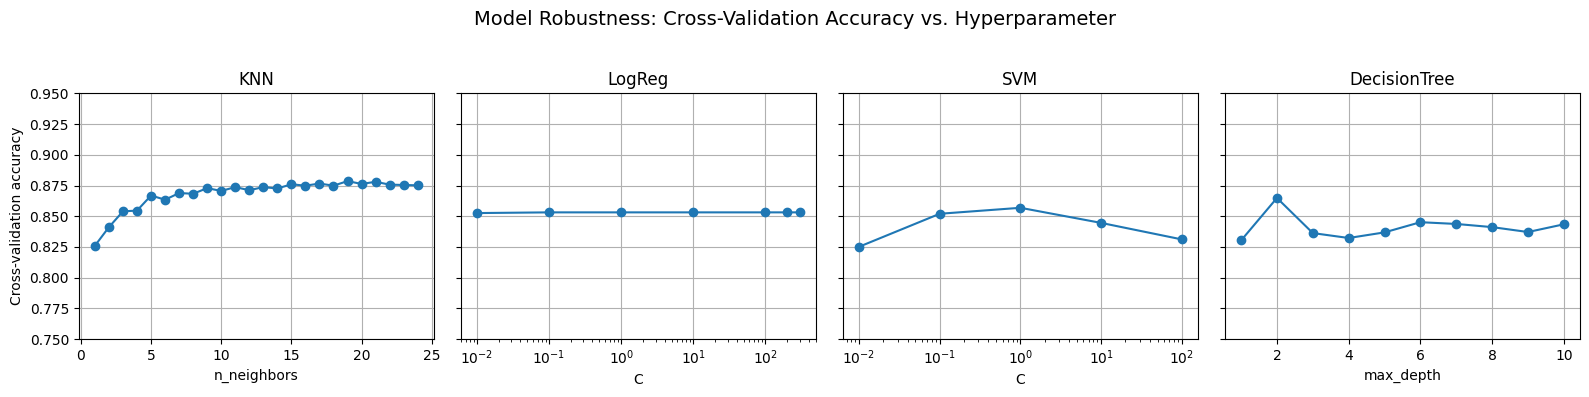

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

models = {
    "KNN": (
        KNeighborsClassifier(),
        {"model__n_neighbors": range(1, 25)}
    ),
    "LogReg": (
        LogisticRegression(max_iter=200, random_state=42, class_weight='balanced'),
        {"model__C": [0.01, 0.1, 1, 10, 100, 200, 300]}
    ),
    "SVM": (
        SVC(class_weight='balanced'),
        {"model__C": [0.01, 0.1, 1, 10, 100]}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        {"model__max_depth": range(1, 11),}
    )
}
# Plot CV performance vs. hyperparameter
cv_results_all = {}

for name, (model, param_grid) in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    param_name = list(param_grid.keys())[0]
    param_values = grid.cv_results_["param_" + param_name].data
    mean_scores = grid.cv_results_["mean_test_score"]
    cv_results_all[name] = (param_values, mean_scores)


fig, axes = plt.subplots(1, len(models), figsize=(16, 4), sharey=True)
fig.suptitle("Model Robustness: Cross-Validation Accuracy vs. Hyperparameter", fontsize=14)

for ax, (name, (x, y)) in zip(axes, cv_results_all.items()):
    ax.plot(x, y, marker="o")
    ax.set_title(name)
    hyperparam = list(models[name][1].keys())[0].replace("model__", "")
    ax.set_xlabel(hyperparam)
    ax.set_xscale("log" if hyperparam == "C" else "linear")
    ax.grid(True)
    ax.set_ylim(0.75, 0.95) 

axes[0].set_ylabel("Cross-validation accuracy")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [46]:
# get the best train accurary and test accuracy for each model
best_models = {}

for name, (model, param_grid) in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_}")


results = {}

for name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results[name] = {
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_test, y_pred_test)
    }


results_df = pd.DataFrame(results).transpose()
results_df

KNN best params: {'model__n_neighbors': 19}
LogReg best params: {'model__C': 0.1}
SVM best params: {'model__C': 1}
DecisionTree best params: {'model__max_depth': 2}


,Train Accuracy,Test Accuracy
KNN,0.885429,0.866000
LogReg,0.857143,0.841333
SVM,0.883714,0.841333
DecisionTree,0.877429,0.875333


In [47]:
dt_model = best_models["DecisionTree"]
y_pred_dt = dt_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_dt)
print(f"DecisionTree test accuracy: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

DecisionTree test accuracy: 0.875

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1206
           1       0.63      0.86      0.73       294

    accuracy                           0.88      1500
   macro avg       0.80      0.87      0.82      1500
weighted avg       0.90      0.88      0.88      1500


Confusion Matrix:
[[1060  146]
 [  41  253]]


for this model:  
96% of “Not Purchased” predictions are correct.  
63% of “Purchased” predictions are correct.    
the recall for purchased class is 86%, the model caputures most buyers

use the model to predict purchase probability to target high-value users.  
only filter users based on purchase probability, but we cannot provide them with the most suitable promotions to maximize conversion rates.


In [48]:
# group the users by their similar behaviors and give them the personalized promotions and visualize the result.(Unsupervised Learning)
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans

# use PCA to reduce the dataset to two dimensions
X_processed = preprocessor.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
ml_data["PCA1"] = X_pca[:, 0]
ml_data["PCA2"] = X_pca[:, 1]

ml_data

,UserID,Country,Referral_Source,Month,Hour,Hour_sin,Hour_cos,Items_In_Cart,Duration_seconds,Purchased,PCA1,PCA2
0,user_1001,Germany,Google,2025-03,8,0.866025,-0.500000,3,368,1,1.256365,1.382206
1,user_1001,Canada,Email,2025-02,15,-0.707107,-0.707107,3,152,0,0.089674,-0.026312
2,user_1002,Germany,Social Media,2025-06,7,0.965926,-0.258819,5,574,1,3.201370,1.265763
3,user_1002,France,Email,2025-05,7,0.965926,-0.258819,0,136,0,-1.221716,1.210229
4,user_1004,Germany,Google,2025-02,8,0.866025,-0.500000,0,98,0,-1.441499,1.339670
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,user_3000,Australia,Social Media,2025-04,23,-0.258819,0.965926,2,377,1,0.946187,-1.186154
4996,user_3001,Australia,Google,2025-08,8,0.866025,-0.500000,3,183,0,0.212274,1.380417
4997,user_3001,France,Google,2025-07,9,0.707107,-0.707107,2,441,1,1.290082,1.454188
4998,user_3001,France,Google,2025-01,16,-0.866025,-0.500000,4,100,0,0.191843,-0.386413


In [ ]:
# use K-Means clustering to group users with similar behavior patterns.
kmeans = KMeans(n_clusters=3, random_state=0)
ml_data["Cluster"] = kmeans.fit_predict(X_pca)
ml_data

,UserID,Country,Referral_Source,Month,Hour,Hour_sin,Hour_cos,Items_In_Cart,Duration_seconds,Purchased,PCA1,PCA2,Cluster
0,user_1001,Germany,Google,2025-03,8,0.866025,-0.500000,3,368,1,1.256365,1.382206,2
1,user_1001,Canada,Email,2025-02,15,-0.707107,-0.707107,3,152,0,0.089674,-0.026312,2
2,user_1002,Germany,Social Media,2025-06,7,0.965926,-0.258819,5,574,1,3.201370,1.265763,2
3,user_1002,France,Email,2025-05,7,0.965926,-0.258819,0,136,0,-1.221716,1.210229,0
4,user_1004,Germany,Google,2025-02,8,0.866025,-0.500000,0,98,0,-1.441499,1.339670,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,user_3000,Australia,Social Media,2025-04,23,-0.258819,0.965926,2,377,1,0.946187,-1.186154,2
4996,user_3001,Australia,Google,2025-08,8,0.866025,-0.500000,3,183,0,0.212274,1.380417,0
4997,user_3001,France,Google,2025-07,9,0.707107,-0.707107,2,441,1,1.290082,1.454188,2
4998,user_3001,France,Google,2025-01,16,-0.866025,-0.500000,4,100,0,0.191843,-0.386413,2


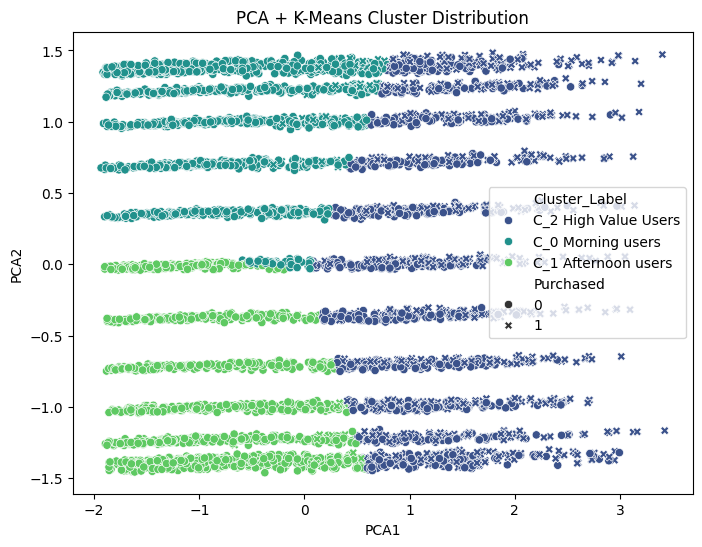

K-Means Cluster Average Features
         Items_In_Cart  Duration_seconds       Hour  Purchased
Cluster                                                       
0             0.814232        172.043451   8.979849   0.050378
1             0.552666        156.944733  14.368010   0.030559
2             3.490395        334.959979  11.646211   0.471185

Cluster sample counts:
Cluster
2    1874
0    1588
1    1538
Name: count, dtype: int64


In [ ]:
cluster_labels = {
    0: "C_0 Morning users",
    1: "C_1 Afternoon users",
    2: "C_2 High Value Users"
}

ml_data["Cluster_Label"] = ml_data["Cluster"].map(cluster_labels)

plt.figure(figsize=(8,6))
sns.scatterplot(data=ml_data, x="PCA1", y="PCA2", hue="Cluster_Label",style="Purchased", palette="viridis")
plt.title("PCA + K-Means Cluster Distribution")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


cluster_summary = ml_data.groupby("Cluster")[["Items_In_Cart", "Duration_seconds", "Hour", "Purchased"]].mean()
print("K-Means Cluster Average Features")
print(cluster_summary)
print("\nCluster sample counts:")
print(ml_data["Cluster"].value_counts())


In [ ]:
# filter users who are in cluster 2, which is high value users, and did not buy yet 
promotion_high_value= ml_data[(ml_data["Purchased"] == 0) & (ml_data["Cluster"] == 2)]
promotion_high_value

,UserID,Country,Referral_Source,Month,Hour,Hour_sin,Hour_cos,Items_In_Cart,Duration_seconds,Purchased,PCA1,PCA2,Cluster,Cluster_Label
1,user_1001,Canada,Email,2025-02,15,-0.707107,-0.707107,3,152,0,0.089674,-0.026312,2,C_2 High Value Users
7,user_1006,USA,Direct,2025-05,11,0.258819,-0.965926,4,248,0,0.986333,1.220098,2,C_2 High Value Users
12,user_1007,Australia,Google,2025-06,8,0.866025,-0.500000,4,309,0,1.321620,1.391487,2,C_2 High Value Users
15,user_1008,Australia,Email,2025-06,15,-0.707107,-0.707107,1,320,0,0.259852,0.033544,2,C_2 High Value Users
17,user_1008,Canada,Google,2025-05,10,0.500000,-0.866025,4,501,0,2.417151,1.400702,2,C_2 High Value Users
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,user_2993,France,Google,2025-05,8,0.866025,-0.500000,5,339,0,1.882355,1.375873,2,C_2 High Value Users
4978,user_2994,India,Google,2025-06,7,0.965926,-0.258819,4,301,0,1.277596,1.231287,2,C_2 High Value Users
4979,user_2994,France,Email,2025-07,5,0.965926,0.258819,4,390,0,1.768581,0.729755,2,C_2 High Value Users
4992,user_2999,Germany,Social Media,2025-01,13,-0.258819,-0.965926,4,273,0,1.144489,0.698116,2,C_2 High Value Users


<p align="center">
  <img src="duration.png" alt="3" width="500"/>
</p>

In [ ]:
# filter users who are in cluster 0, and have items in their carts
promotion_morning_users = ml_data[(ml_data["Purchased"] == 0) & (ml_data["Cluster"] == 0)&(ml_data["Items_In_Cart"] > 0)]
promotion_morning_users

,UserID,Country,Referral_Source,Month,Hour,Hour_sin,Hour_cos,Items_In_Cart,Duration_seconds,Purchased,PCA1,PCA2,Cluster,Cluster_Label
29,user_1011,UK,Google,2025-03,5,0.965926,2.588190e-01,1,144,0,-0.795460,0.691233,0,C_0 Morning users
48,user_1017,UK,Email,2025-02,9,0.707107,-7.071068e-01,1,172,0,-0.624362,1.396224,0,C_0 Morning users
53,user_1020,France,Social Media,2025-03,6,1.000000,6.123234e-17,3,198,0,0.300524,0.982480,0,C_0 Morning users
56,user_1020,France,Email,2025-05,11,0.258819,-9.659258e-01,2,309,0,0.562113,1.235038,0,C_0 Morning users
96,user_1035,Australia,Direct,2025-03,7,0.965926,-2.588190e-01,1,187,0,-0.560148,1.234157,0,C_0 Morning users
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,user_2996,France,Email,2025-05,11,0.258819,-9.659258e-01,2,242,0,0.183382,1.223508,0,C_0 Morning users
4983,user_2996,Canada,Google,2025-06,8,0.866025,-5.000000e-01,3,260,0,0.656904,1.370527,0,C_0 Morning users
4989,user_2998,France,Direct,2025-08,13,-0.258819,-9.659258e-01,1,235,0,-0.245596,0.730290,0,C_0 Morning users
4991,user_2999,UK,Google,2025-02,7,0.965926,-2.588190e-01,1,275,0,-0.052242,1.227225,0,C_0 Morning users
